In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Construct model
model = Sequential()
model.add(Dense(100, input_shape=[2,], activation='selu'))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Flatten())
model.add(Dense(1))

In [3]:
def theta2cart(theta, r): # converts random thetas and fixed r into x and y coordinates
    x_out = tf.math.multiply(r, tf.math.cos(theta)) # x = 4cos(theta_in)
    y_out = tf.math.multiply(r, tf.math.sin(theta)) # y = 4sin(theta_in)
    
    pts = tf.transpose(tf.stack([x_out,y_out],0))
    return pts

In [4]:
def out_bnd_fn(theta_out): # f(4,theta) = 4sin(5theta)
    f_true = tf.transpose(tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5,theta_out))))
    return f_true

In [5]:
# Used as pre-training to train the network to satisfy the boundary condition
def out_bnd_loss_fn(f_pred, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
#     f_pred = tf.squeeze(f_pred)
#     print("f_pred shape" ,tf.shape(f_pred))

# Find loss for outer boundary points #####################################################################
    f_true =  out_bnd_fn(theta_out)
#     f_true = tf.squeeze(f_true)
#     print("t_true shape", tf.shape(f_true))
#     print(tf.shape(trainable_weights))
#     regulizer = tf.nn.l2_loss(trainable_weights)
# out_bnd_err = f(x,y)-4sin(5theta)

    loss = tf.keras.metrics.mean_squared_error(f_true,f_pred) # MSE outer bound points
    return loss

In [6]:
# Used as pre-training to train the network to satisfy the boundary condition
def out_bnd_train_for():

# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.1) # Fancy gradient decent
    epochs = 200
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    theta_out_size = 100 # Number of outer boundary points to sample each iteration

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            out_bnd_pts = theta2cart(theta_out,4)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                f_pred = model(out_bnd_pts, training=True)
                loss = out_bnd_loss_fn(f_pred, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            #optimizer.minimize(loss_fn(model, theta_out), model.trainable_weights)
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 10 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [7]:
def loss_fn(model, int_pts, theta_in, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
    
# Find loss for interior points ###########################################################################
    with tf.GradientTape() as tt:
        tt.watch(int_pts)
        with tf.GradientTape() as t:
            t.watch(int_pts)
            g = model(int_pts)
#         print('g = ', g)
        grad_g = t.gradient(g, int_pts) 
    laplace_g = tt.gradient(grad_g, int_pts)
#     print(grad_g)
#     dg_dx = grad_g[0:,0,0] # dg/dx
#     print(dg_dx)
#     dg_dy = grad_g[0:,0,1] # dg/dy
    laplace_g_l2_norm = tf.nn.l2_loss(laplace_g) # Dirichlet energies / 2
    
# Find loss for inner boundary points #####################################################################
    in_bnd_pts = theta2cart(theta_in, 2)
    in_bnd_true = tf.zeros(tf.shape(theta_in))
    in_bnd_pred = model(in_bnd_pts) # in_bnd_err = g(x,y)-0
#     print("in_bnd_pred shape: ", tf.shape(in_bnd_pred))
    in_bnd_mse = tf.keras.metrics.mean_squared_error(in_bnd_pred, in_bnd_true) # MSE inner bound points
#     print("in_bnd_mse = ", in_bnd_mse)
    
# Find loss for outer boundary points #####################################################################    
    out_bnd_pts = theta2cart(theta_out,4)
    out_bnd_true = out_bnd_fn(theta_out)
    out_bnd_pred = model(out_bnd_pts) # MSE outer bound points
#     print("out_bnd_pred shape: ", tf.shape(out_bnd_pred))
    out_bnd_mse = tf.keras.metrics.mean_squared_error(out_bnd_pts, out_bnd_pred)
#     print("out_bnd_mse = ", out_bnd_mse)

# Find total weighted boundary error ######################################################################
    bnd_err = in_bnd_mse + out_bnd_mse

# Total loss ##############################################################################################
    loss = tf.math.add(laplace_g_l2_norm, bnd_err)
    
    return loss

In [9]:
# Train network
def train_for():
    
# Train network on outer boundary first ###################################################################
    print('Training outer bound...')
    out_bnd_train_for()

# Define training parameters ##############################################################################    
    print('Training network on all conditions...')
    
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    epochs = 10000
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    int_pts_size = 1000 # Number of interior points to sample each iteration
    theta_in_size = 1000 # Number of inner boundary points to sample each iteration
    theta_out_size = 1000 # Number of outer boundary points to sample each iteration


    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
# Sample interior points ##################################################################################
            r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
                tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1,int_pts_size], minval=0, maxval=1))))
            theta_int = tf.random.uniform([1,int_pts_size], minval=0, maxval=2*np.pi)
            
            # Convert to cartestian
#             x_int = tf.math.multiply(r_int, tf.math.cos(theta_int)) 
#             y_int = tf.math.multiply(r_int, tf.math.sin(theta_int))
#             int_pts = tf.transpose(tf.stack([x_int, y_int], 0))
            int_pts = theta2cart(theta_int, r_int)
    
# Sample inner bound thetas ###############################################################################    
            theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = loss_fn(model, int_pts, theta_in, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 100 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [10]:
train_for()

Training outer bound...
Epoch 000: Loss: 240153.469
Epoch 010: Loss: 0.968
Epoch 020: Loss: 0.382
Epoch 030: Loss: 0.234
Epoch 040: Loss: 0.148
Epoch 050: Loss: 0.118
Epoch 060: Loss: 0.096
Epoch 070: Loss: 0.074
Epoch 080: Loss: 0.063
Epoch 090: Loss: 0.054
Epoch 100: Loss: 0.048
Epoch 110: Loss: 0.048
Epoch 120: Loss: 0.043
Epoch 130: Loss: 0.039
Epoch 140: Loss: 0.038
Epoch 150: Loss: 0.034
Epoch 160: Loss: 0.027
Epoch 170: Loss: 0.026
Epoch 180: Loss: 0.023
Epoch 190: Loss: 0.020
Training network on all conditions...
Epoch 000: Loss: 139915744.000
Epoch 100: Loss: 2761782.750
Epoch 200: Loss: 655543.438
Epoch 300: Loss: 353840.781
Epoch 400: Loss: 242810.500
Epoch 500: Loss: 196205.203
Epoch 600: Loss: 155015.453
Epoch 700: Loss: 113006.930
Epoch 800: Loss: 100344.883
Epoch 900: Loss: 97091.164
Epoch 1000: Loss: 86017.977
Epoch 1100: Loss: 75878.203
Epoch 1200: Loss: 68054.883
Epoch 1300: Loss: 55122.004
Epoch 1400: Loss: 48894.039
Epoch 1500: Loss: 45088.680
Epoch 1600: Loss: 3973

In [11]:
# Generate test points to plot ############################################################################
in_bnd_pts_size = 1000 # Number of inner boundary points to sample 
out_bnd_pts_size = 1000 # Number of outer boundary points to sample 
int_pts_size = 1000 # Number of interior points to sample

# Sample interior points ##################################################################################
r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
    tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1, int_pts_size], minval = 0, maxval=1))))
theta_int = tf.random.uniform([1, int_pts_size], minval=0, maxval=2*np.pi)
# Convert to cartestian
int_pts = theta2cart(theta_int, r_int)

# Sample inner boundary points ############################################################################
theta_in = tf.random.uniform([1, in_bnd_pts_size], minval=0, maxval=2*np.pi)
in_bnd_pts = theta2cart(theta_in, 2)

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
out_bnd_pts = theta2cart(theta_out, 4)
# print(out_bnd_pts.shape)
# print(out_bnd_pts)

test_pts = tf.concat([int_pts, in_bnd_pts, out_bnd_pts],0)
# print(test_pts)
print("test_pts_shape: ", test_pts.shape)

z = model(test_pts)
print("z shape: ", tf.shape(z))

test_pts_shape:  (3000, 1, 2)
z shape:  tf.Tensor([3000    1], shape=(2,), dtype=int32)


(3000,)
(3000,)
(3000,)


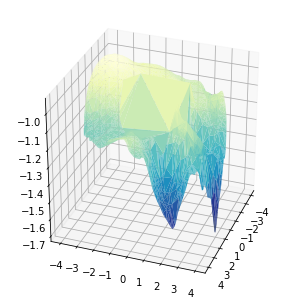

In [13]:
# Plot ####################################################################################################
fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z[0:, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.YlGnBu_r)
ax.view_init(30, 20)
plt.show()

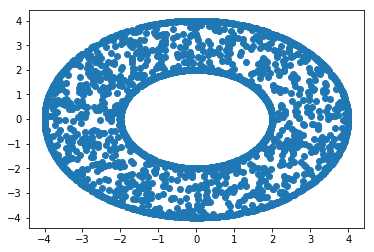

In [14]:
plt.scatter(X,Y)
plt.show()